In [1]:
from plotnine import *
from functions import *
import xgboost as xgb

# Output analysis

In [2]:
lambda_list = [0.1, 0.316, 0.5, 1.0, 10.0]
name_beg = 'results_FAIR_tuned_LR_FAIR_big_lambda' 
name_end = '_frac1.0.csv'

res_df = pd.DataFrame()

for lam in lambda_list:
    res_name = name_beg + str(lam) + name_end
    res_df = pd.concat([res_df,pd.read_csv(here('output/'+res_name)).dropna()])


In [5]:
# Results regular regression
res_reg_df = pd.read_csv(here('output/results_REGULAR_tuned_LR_big_lambda0.0_frac1.0.csv')).dropna().assign() 
res_reg_df = res_reg_df.rename(columns={'UTILITY_PRODUCT_FAIR':r'$\widetilde{U}$', 'UTILITY': 'U','AU-ROC': 'AUC'})
res_reg_df = res_reg_df.melt(id_vars=['model','iteration'], var_name='metric').groupby(['metric','model']).mean().reset_index()
res_reg_df = res_reg_df.loc[res_reg_df['metric'].isin(['AUC','DP','NLLH','U',r'$\widetilde{U}$']),:]

In [6]:
data_plot = res_df.drop(['AVG-P-SCORE','UTILITY_PRODUCT'],axis=1).rename(columns={'UTILITY_PRODUCT_FAIR':r'$\widetilde{U}$', 'UTILITY': 'U','AU-ROC': 'AUC'}).melt(
    id_vars=["model", "fairness_multiplier", "fairness_fraction", "iteration"],
    var_name="metric",
    value_name="value",
)
data_plot2 = data_plot.groupby(["model", "fairness_multiplier", "fairness_fraction", "metric"])["value"].agg('mean').reset_index()
data_plot2['l2std'] = data_plot.groupby(["model", "fairness_multiplier", "fairness_fraction", "metric"])["value"].agg(lambda x: np.mean(x) - 2 * np.std(x)).values
data_plot2['u2std'] = data_plot.groupby(["model", "fairness_multiplier", "fairness_fraction", "metric"])["value"].agg(lambda x: np.mean(x) + 2 * np.std(x)).values

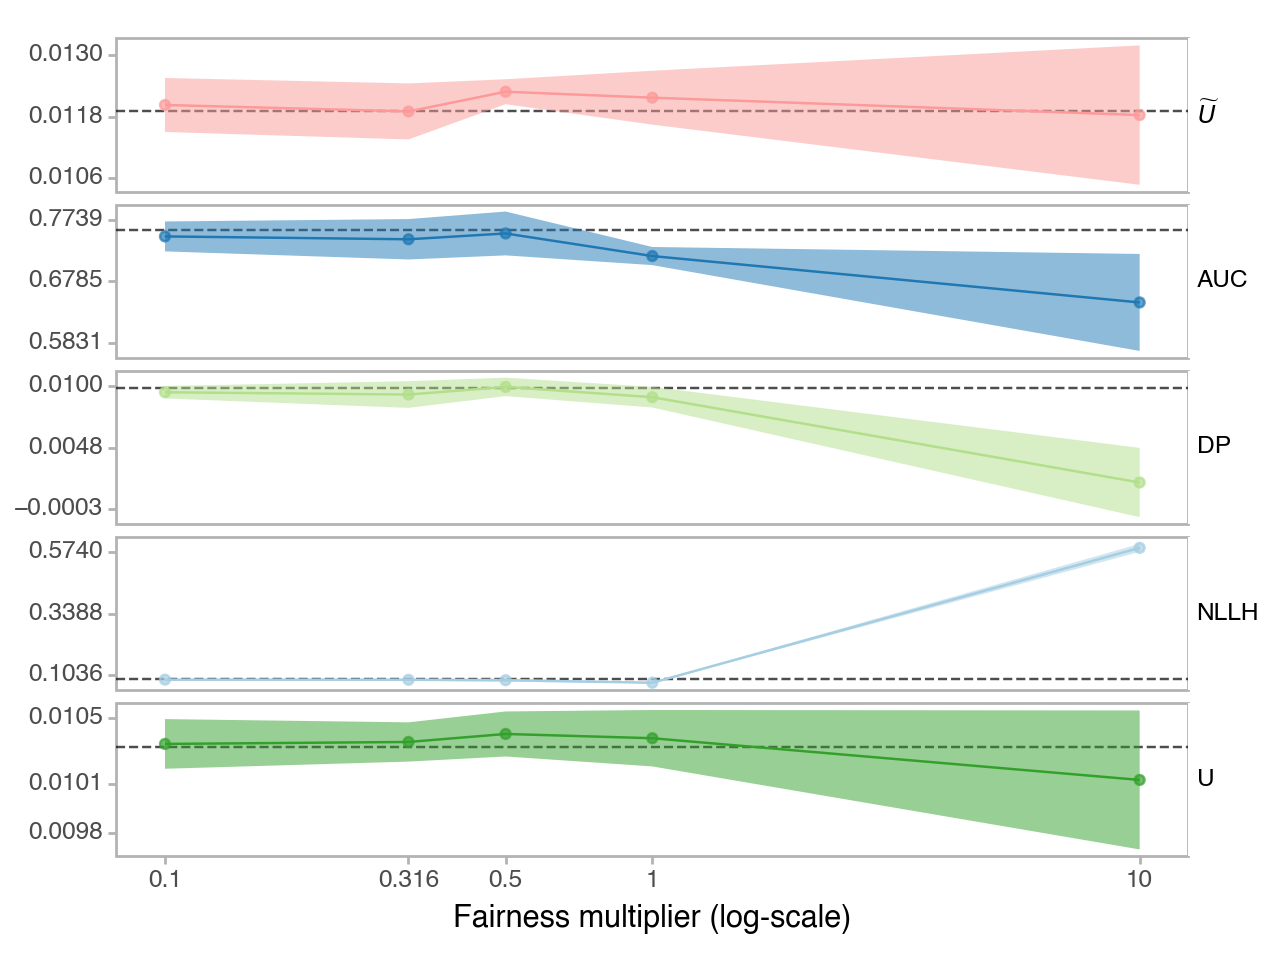

<Figure Size: (640 x 480)>

In [7]:
data_plot2['metric'] = pd.Categorical(data_plot2['metric'], categories=['NLLH','AUC','DP','U',r'$\widetilde{U}$'])

def break_make(limits):
      range = limits[1] - limits[0]
      return np.round(np.linspace(limits[0] + 0.1*range, limits[1] - 0.1*range,num=3), decimals=4)

plot_metrics = (ggplot(data_plot2, aes(x='fairness_multiplier',y='value'))+
 geom_hline(data=res_reg_df, mapping=aes(yintercept='value'), alpha=0.7, linetype='dashed') +
 geom_line(aes(color='metric')) +
 geom_point(aes(color='metric'), alpha=0.7) +
 geom_ribbon(aes(ymin='l2std',ymax='u2std', fill='metric'),alpha=0.5) +
 scale_x_log10(breaks=lambda_list) + 
 scale_y_continuous(breaks=break_make) +
 scale_color_brewer(type='qual',palette='Paired') +
 scale_fill_brewer(type='qual', palette='Paired') +
 labs(x='Fairness multiplier (log-scale)') +
 facet_grid('metric~.', scales='free_y') +
 theme_light() +
 guides(fill=False, color=False) +
 theme(panel_grid=element_blank(),
       axis_title_y=element_blank(),
       strip_background=element_rect(fill='white', linewidth=0),
       strip_text=element_text(color='black', angle=0)))

plot_metrics

### Figure 5: Density plot unfair, unaware, with fairness penalty

In [8]:
data_pred_fair = pd.read_csv(here('output/SINGLE_pred_LR_FAIR_lambda3.0_frac1.0.csv')).drop('Unnamed: 0',axis=1)
data_pred_ftu = pd.read_csv(here('output/SINGLE_pred_LR_UNAWARE_lambda0.0_frac1.0.csv')).drop('Unnamed: 0',axis=1)
data_pred_lr = pd.read_csv(here('output/SINGLE_pred_LR_UNFAIR_lambda0.0_frac1.0.csv')).drop('Unnamed: 0',axis=1)

data_pred_single_u = pd.concat([data_pred_fair.assign(fair='fair'),data_pred_ftu.assign(fair='ftu'), data_pred_lr.assign(fair='unfair')])
data_pred_single_u = data_pred_single_u.loc[data_pred_single_u['y_test'].eq(1)]

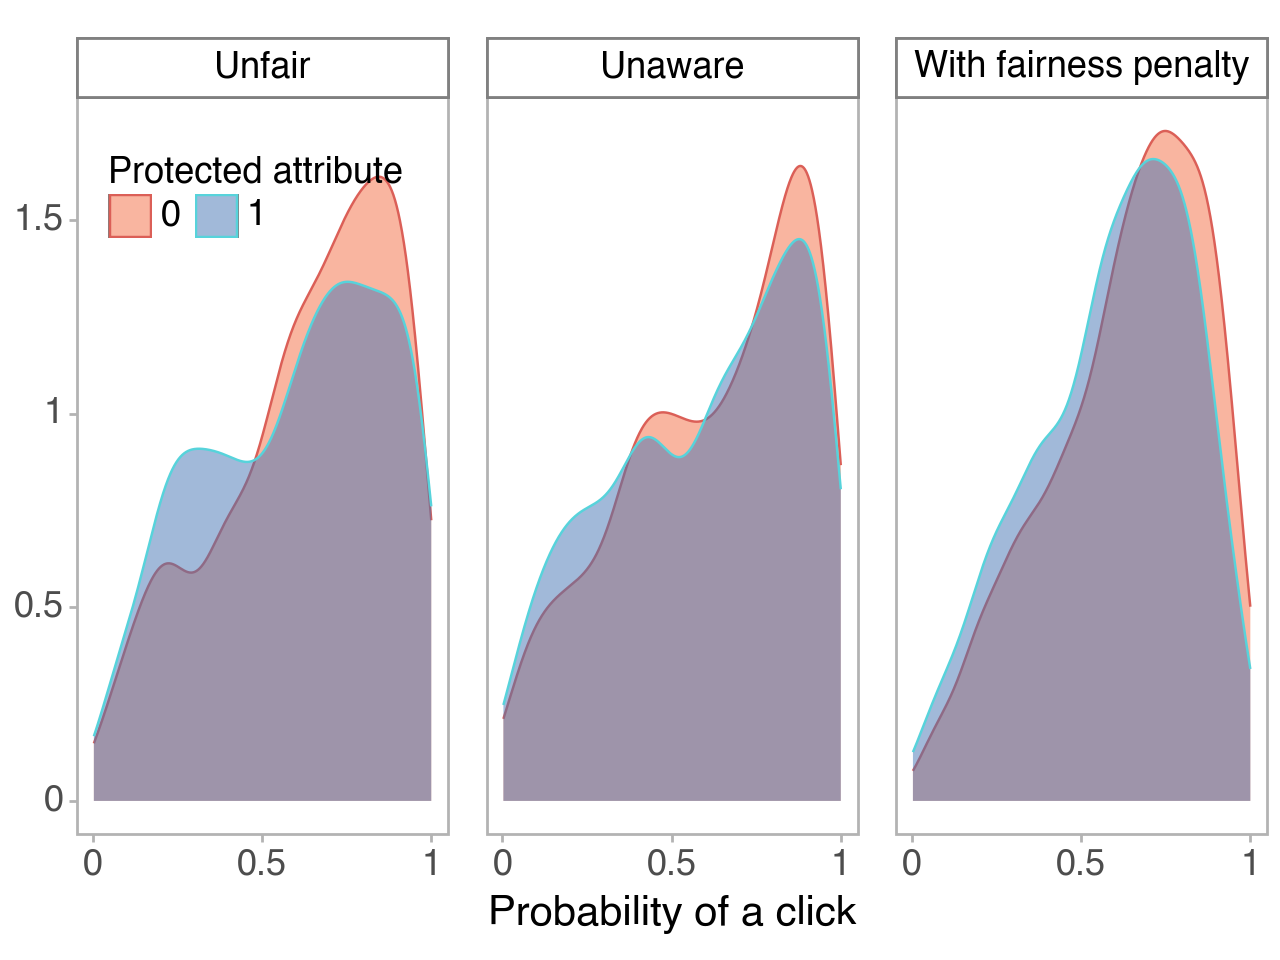

<Figure Size: (640 x 480)>

In [9]:
data_plot= data_pred_single_u.loc[:,['fair','prob_test','a_test']]
data_plot['prob_test'] = data_plot['prob_test'] 
data_plot['a_test'] = data_plot['a_test'].astype(str)
data_plot.rename(columns={'a_test':'Protected attribute'}, inplace=True)
map_dict = {'fair': 'With fairness penalty', 'unfair': 'Unfair', 'ftu': 'Unaware'}
data_plot['fair'] = data_plot['fair'].apply(lambda x: map_dict[x])
data_plot['fair'] = pd.Categorical(data_plot['fair'], categories=["Unfair", "Unaware", "With fairness penalty"])

plot_probs = (ggplot(data_plot,aes(x='prob_test', 
                      fill='Protected attribute', 
                      color='Protected attribute'))+
 scale_x_continuous(breaks=[0.0,0.5,1.0]) +
 geom_density(alpha=0.5) +
 scale_fill_manual(values=['#f46d43','#4575b4']) +
 labs(x='Probability of a click',)+
 facet_grid('.~fair') +
 theme_light() +
 theme(panel_grid=element_blank(),
       axis_title_y=element_blank(),
       legend_background = element_rect(fill='none'),
       legend_position = (0.2,0.8),
       panel_spacing = 0.03,
       strip_background=element_rect(color = 'gray', fill = 'white'),
       strip_text_x = element_text(color = 'black',size=13),
       legend_text=element_text(size=13.0),
       legend_title=element_text(size=13.0),
       axis_title=element_text(size=15.0),
       axis_text=element_text(size=13.0)
       ))
plot_probs


# Dataset summaries and plots

In [10]:
(
    X,
    y,
    protected_attribute,
    is_senior,
    displayrandom,
    rank,
    categorical_features_cardinalities,
) = load_data()

X_id_df = pd.DataFrame(X[:,0:3]).rename(columns={0: 'user_id', 1: 'impression_id', 2:'product_id'})
X_id_df = X_id_df.astype('category')
X_id_df = X_id_df.assign(click=y, senior=is_senior)

X_r_df = pd.DataFrame({'y': y,
                       'r': rank,
                       'd': displayrandom})

#### Paper Figure 8: Click per rank

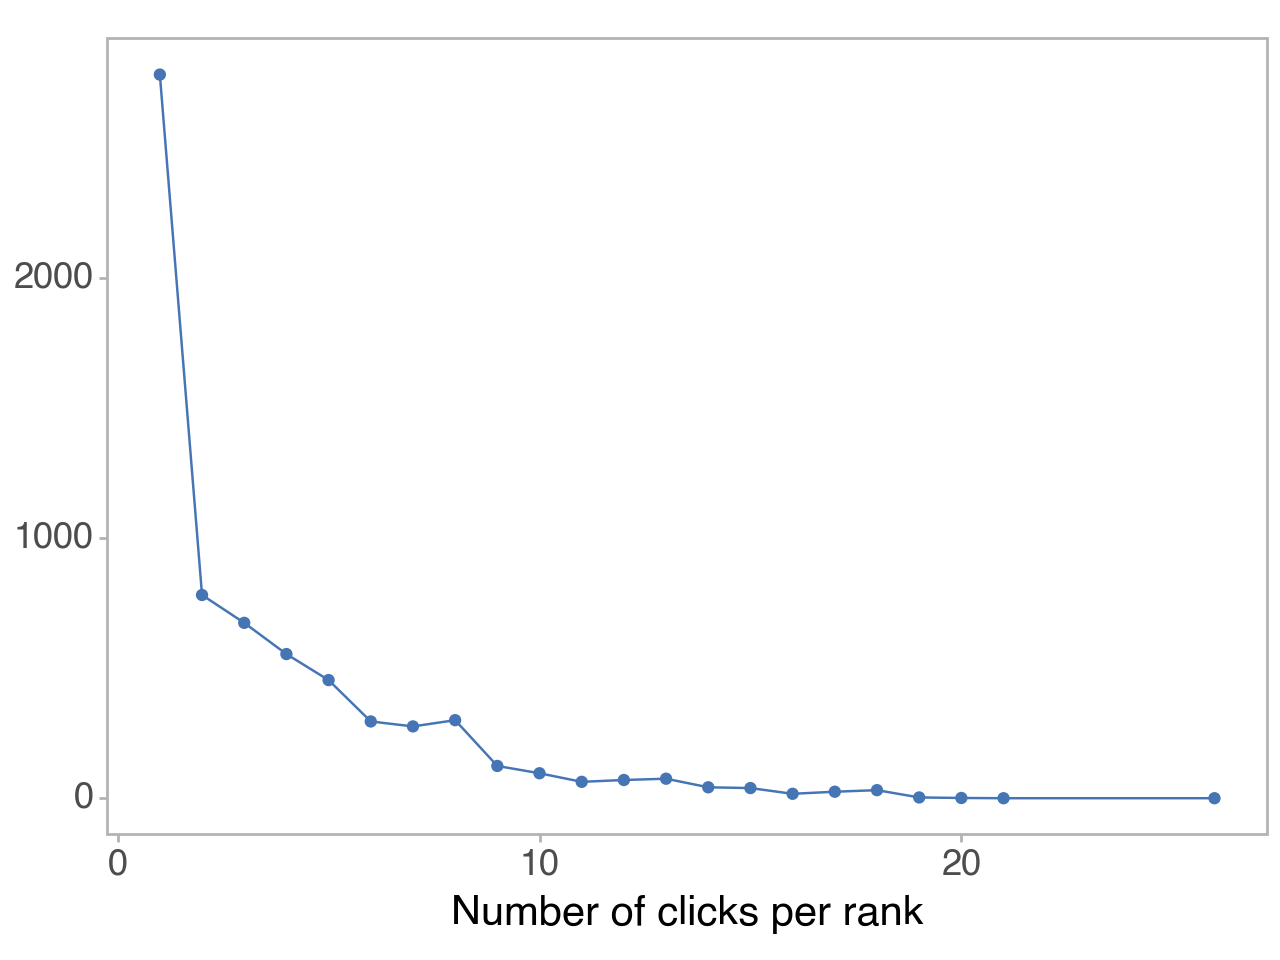

<Figure Size: (640 x 480)>

In [9]:
data = pd.DataFrame({'rank': X_r_df.loc[X_r_df['y'].eq(1.0) & X_r_df['d'].eq(0.0),'r'].astype(int)})
data = data.assign(count=1).groupby('rank').sum().reset_index()
plot_npclick_perrank = (ggplot(data, aes(x='rank', y='count')) +
 geom_point(color='#4575b4') +
 geom_line(color='#4575b4') +
 labs(x='Number of clicks per rank') +
 guides(fill="none") + 
 theme_light() + 
 theme(panel_grid=element_blank(),
       axis_title_y=element_blank(),
       axis_title=element_text(size=15.0),
       axis_text=element_text(size=13.0)))
plot_npclick_perrank 
                            

#### Paper Figure 8: Number of products per user

/var/folders/dz/3kkg2h9x64392v3r6knhsnyc0000gq/T/ipykernel_18315/2332698317.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


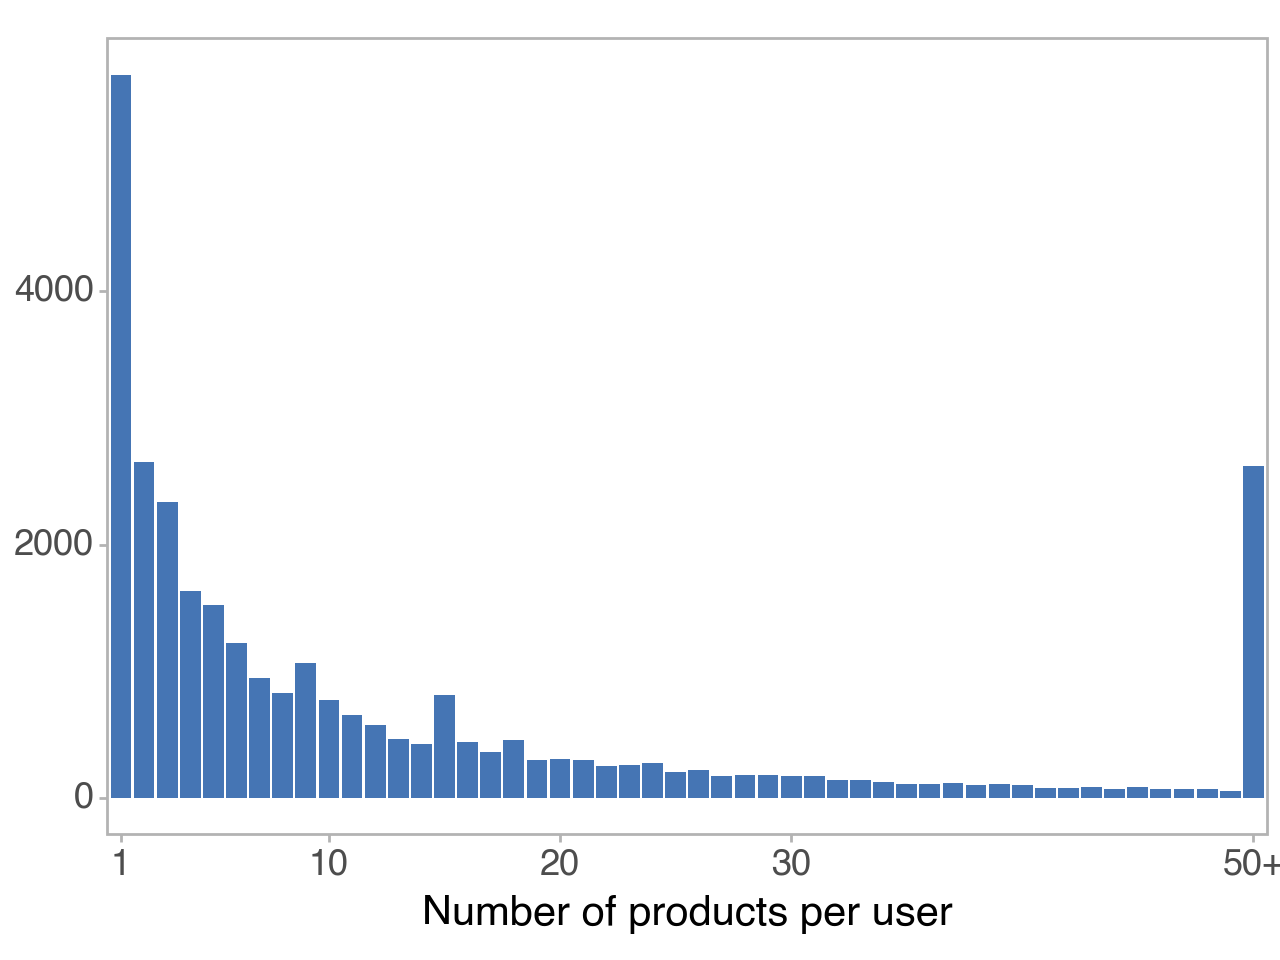

<Figure Size: (640 x 480)>

In [10]:
nproduct_peruser = X_id_df.groupby('user_id')['product_id'].nunique().apply(lambda x: str(x) if x<50 else '50+')

data = pd.DataFrame({'nproduct_peruser': nproduct_peruser})
data['plus_flag'] = data['nproduct_peruser'].eq('50+').astype('category')
plot_nproduct_peruser = (ggplot(data, aes(x='nproduct_peruser', fill='plus_flag')) + 
 geom_bar() +
 scale_x_discrete(limits=[str(num) for num in range(1,50)] + ['50+'],
                  breaks = [str(num) for num in [1,10,20,30]] + ['50+']) + 
 scale_fill_manual(values=['#4575b4','#4575b4',]) +
 labs(x='Number of products per user') +
 guides(fill=False) + 
 theme_light() + 
 theme(panel_grid=element_blank(),
       axis_title_y=element_blank(),
       axis_title=element_text(size=15.0),
       axis_text=element_text(size=13.0)))
plot_nproduct_peruser
                            

#### Paper Figure 8: Number of impressions per user

/var/folders/dz/3kkg2h9x64392v3r6knhsnyc0000gq/T/ipykernel_18315/39941415.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


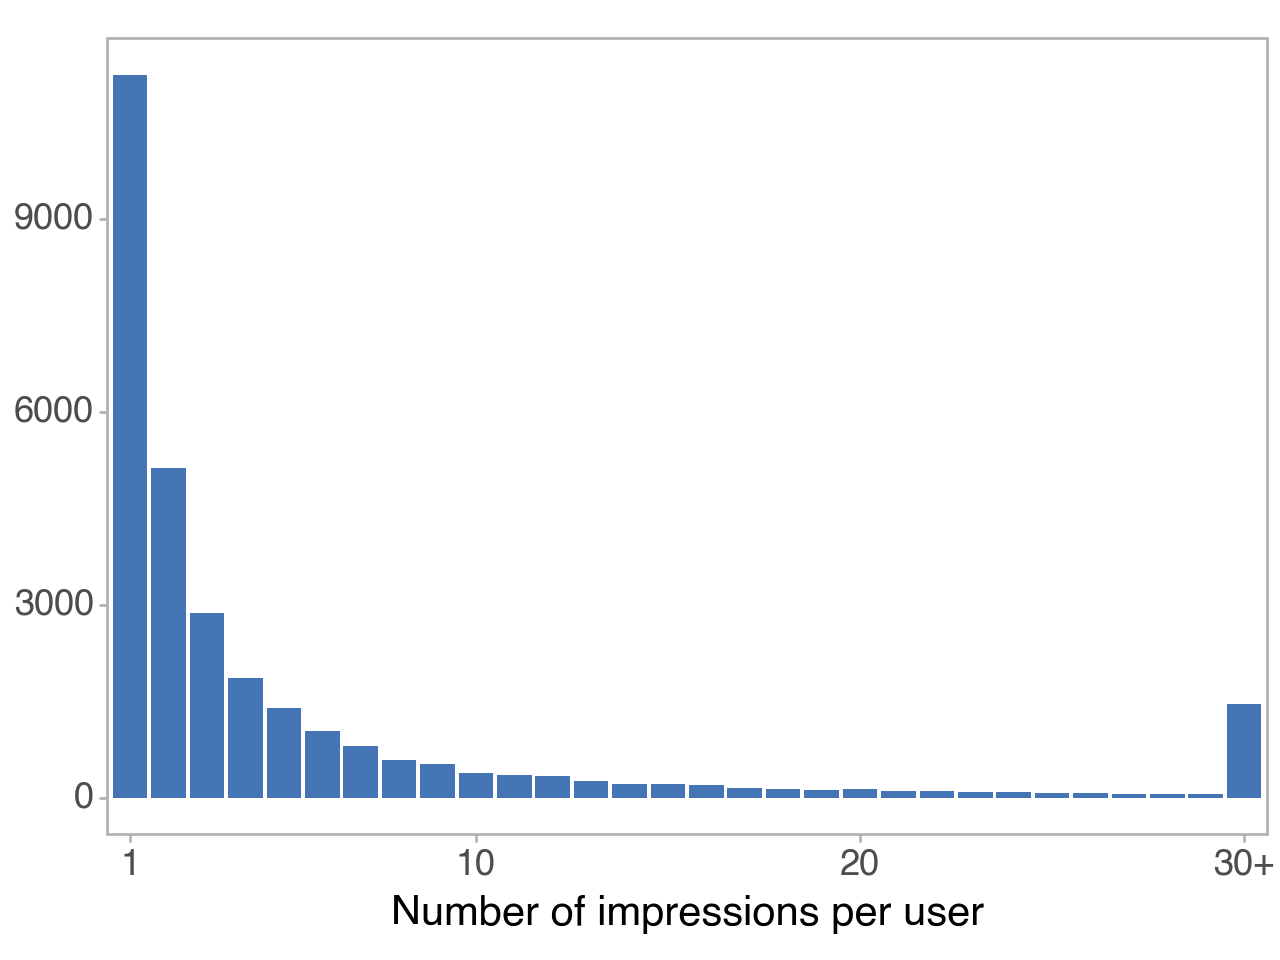

<Figure Size: (640 x 480)>

In [11]:
nimpression_peruser = X_id_df.groupby('user_id')['impression_id'].nunique().apply(lambda x: str(x) if x<30 else '30+')

data = pd.DataFrame({'nimpression_peruser': nimpression_peruser})
data['plus_flag'] = data['nimpression_peruser'].eq('30+').astype('category')
plot_nimpression_peruser = (ggplot(data, aes(x='nimpression_peruser', fill='plus_flag')) + 
 geom_bar() +
 scale_x_discrete(limits=[str(num) for num in range(1,30)] + ['30+'],
                  breaks = [str(num) for num in [1,10,20]] + ['30+']) + 
 scale_fill_manual(values=['#4575b4','#4575b4',]) +
 labs(x='Number of impressions per user') +
 guides(fill=False) + 
 theme_light() + 
 theme(panel_grid=element_blank(),
       axis_title_y=element_blank(),
       axis_title=element_text(size=15.0),
       axis_text=element_text(size=13.0)))
plot_nimpression_peruser


#### Paper Figure 8: Banner size 

/var/folders/dz/3kkg2h9x64392v3r6knhsnyc0000gq/T/ipykernel_18315/2497031606.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


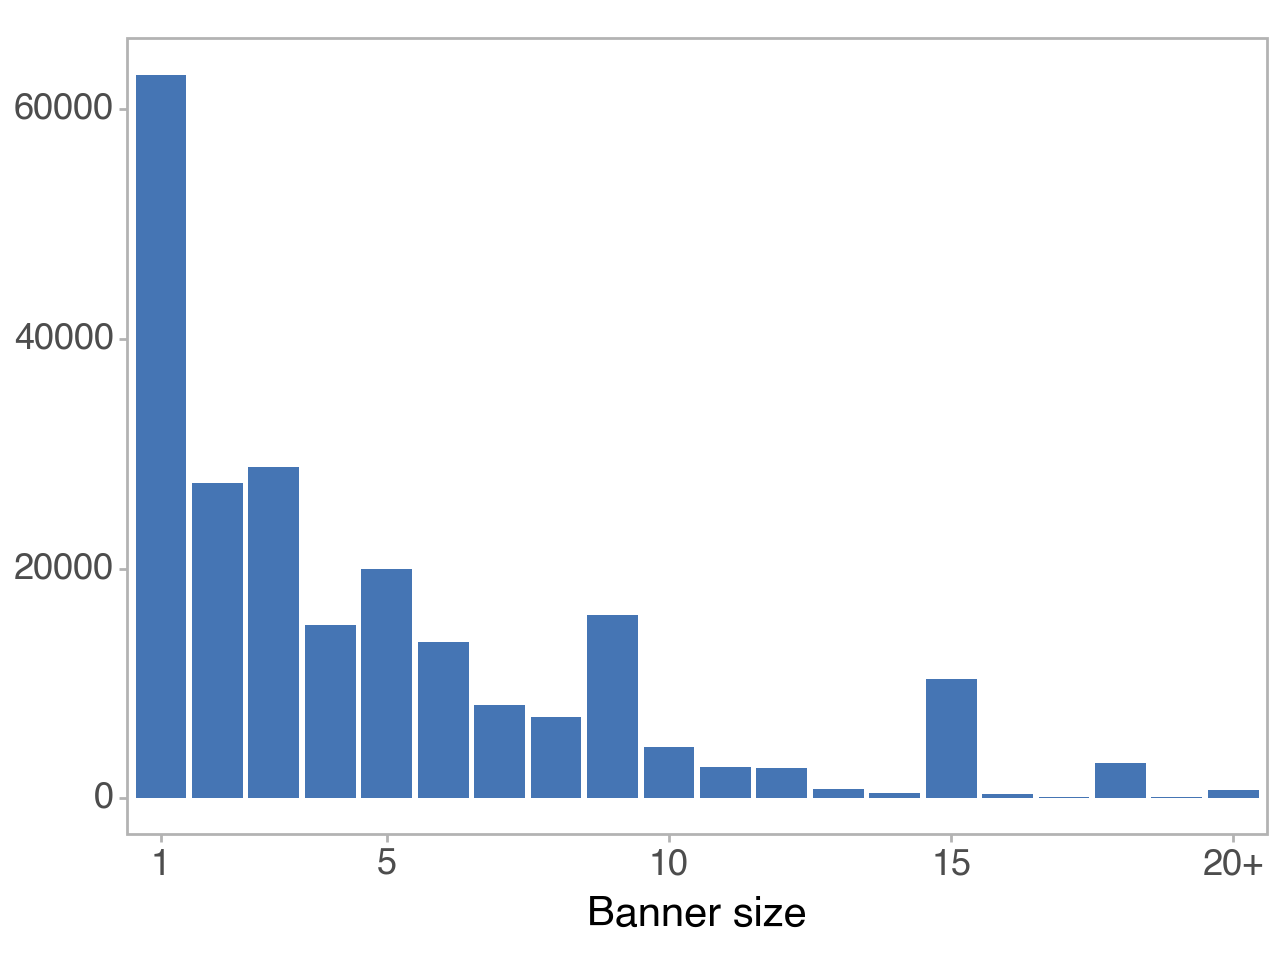

<Figure Size: (640 x 480)>

In [12]:
banner_size = X_id_df.groupby('impression_id')['product_id'].nunique().apply(lambda x: str(x) if x<20 else '20+')
data = pd.DataFrame({'banner_size': banner_size})
data['plus_flag'] = data['banner_size'].eq('20+').astype('category')

plot_banner_size = (ggplot(data, aes(x='banner_size', fill='plus_flag')) + 
 geom_bar() +
 scale_x_discrete(limits=[str(num) for num in range(1,20)] + ['20+'],
                  breaks = [str(num) for num in [1,5,10,15]] + ['20+']) + 
 scale_fill_manual(values=['#4575b4','#4575b4',]) +
 labs(x='Banner size') +
 theme_light() + 
 guides(fill=False) + 
 theme(panel_grid=element_blank(),
       axis_title_y=element_blank(),
       axis_title=element_text(size=15.0),
       axis_text=element_text(size=13.0)))
plot_banner_size

#### Paper Figure 8: Product frequency 

/var/folders/dz/3kkg2h9x64392v3r6knhsnyc0000gq/T/ipykernel_18315/2639559108.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/dz/3kkg2h9x64392v3r6knhsnyc0000gq/T/ipykernel_18315/2639559108.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


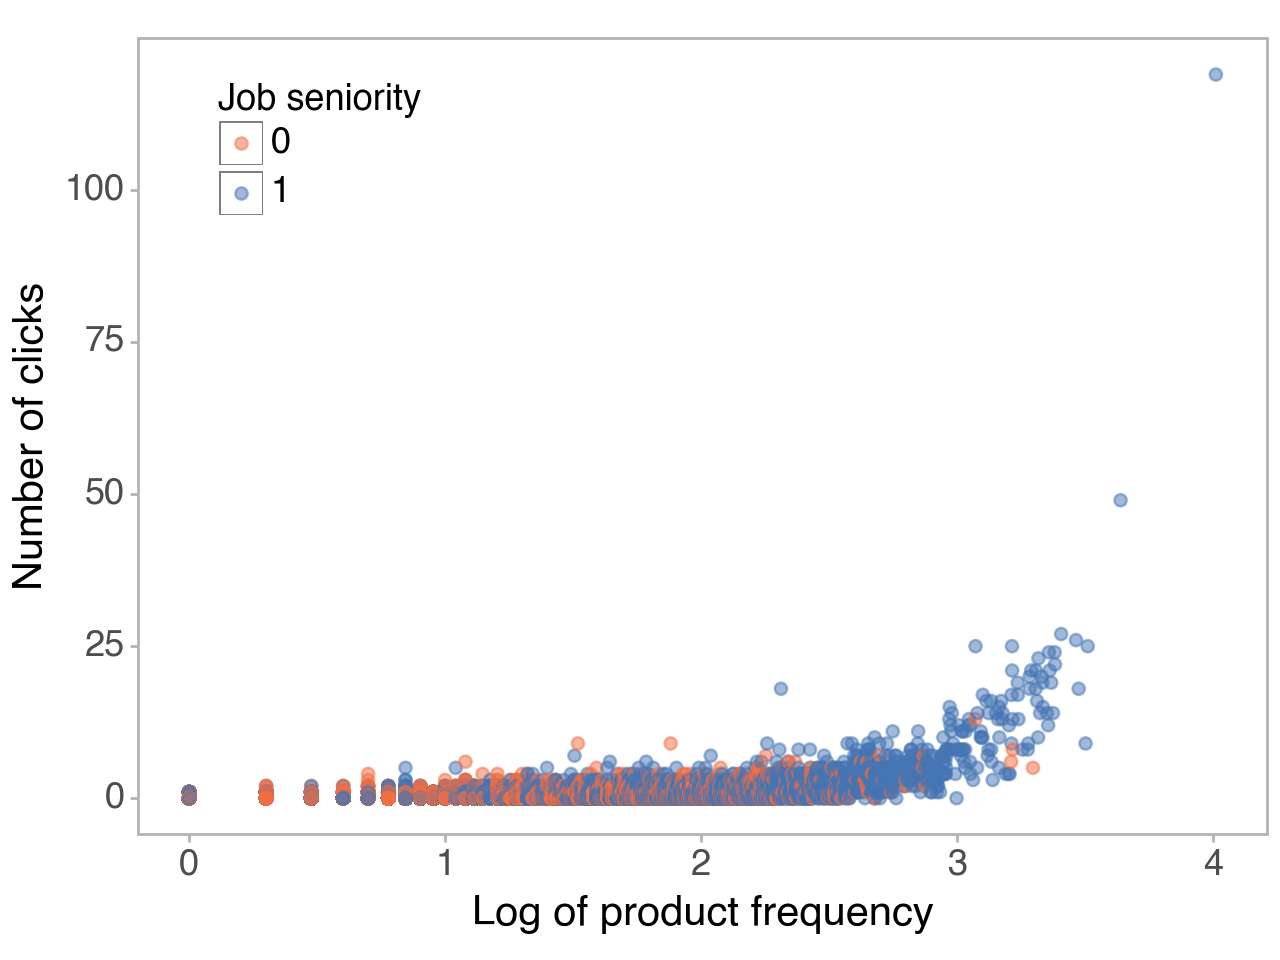

<Figure Size: (640 x 480)>

In [13]:
n_click_perproduct = X_id_df.groupby('product_id')['click'].sum()
prod_freq = X_id_df['product_id'].value_counts().sort_index().apply(np.log10)
seniority_prod = X_id_df.groupby('product_id')['senior'].agg('first').astype(int).astype('category')#.astype(str)


data = pd.concat([n_click_perproduct,prod_freq,seniority_prod],axis=1).sort_values('count')
plot_prod = (ggplot(data, aes(x='count', y='click', color='senior')) +
 geom_point(size=2, alpha = 0.5) +
 scale_color_manual(values=['#f46d43', '#4575b4']) +
 labs(y='Number of clicks',
      x='Log of product frequency',
      color='Job seniority') + 
 theme_light() + 
 theme(panel_grid=element_blank(),
       legend_direction='vertical',
       legend_position=(0.25,0.85),
       legend_text=element_text(size=13.0),
       legend_title=element_text(size=13.0),
       axis_title=element_text(size=15.0),
       axis_text=element_text(size=13.0)))
plot_prod



### Paper Figure 10: Correlation between numerical features in FairJob dataset

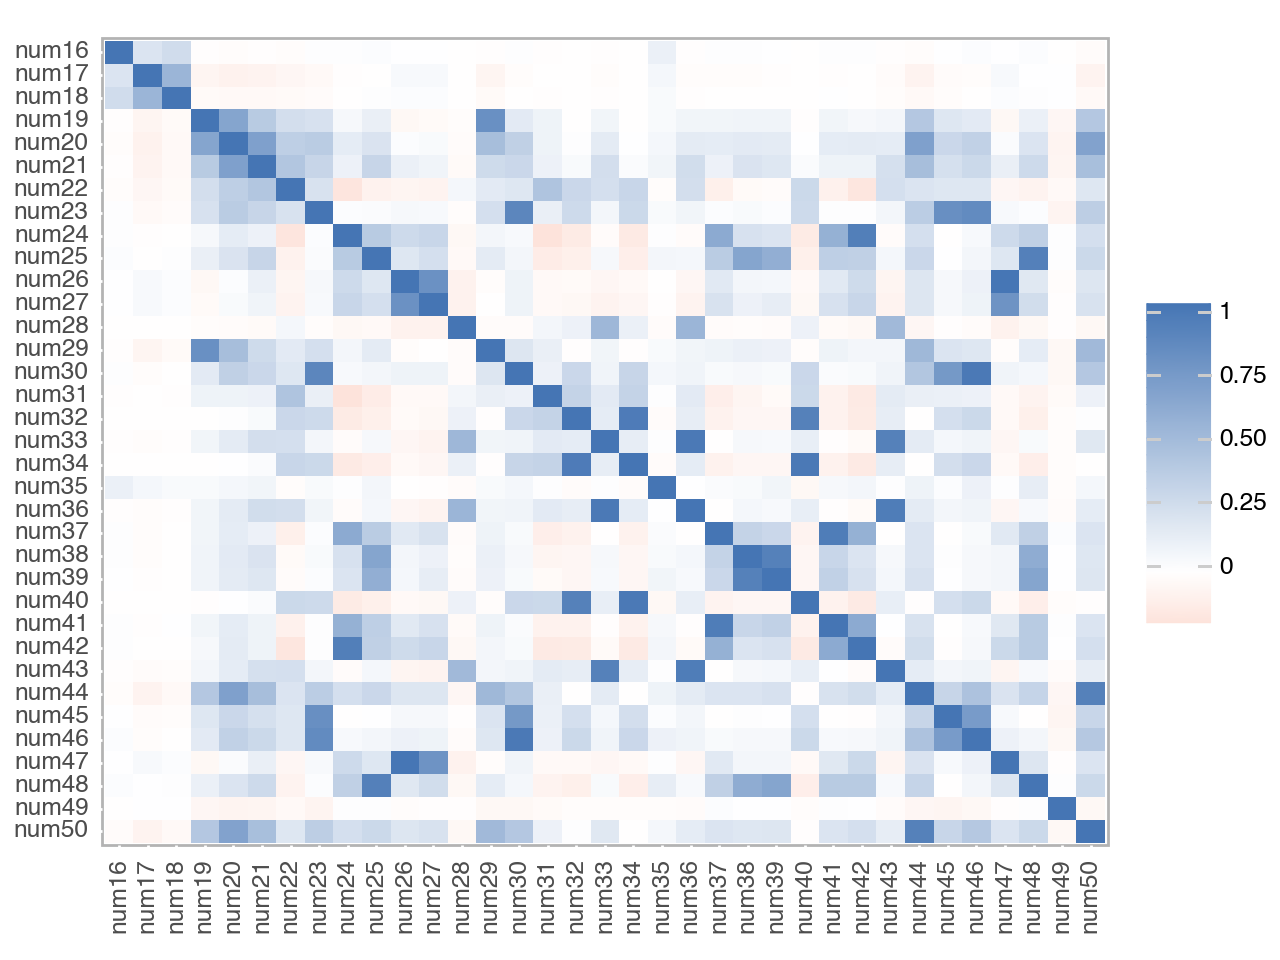

<Figure Size: (640 x 480)>

In [14]:
col_order = list(range(1+max(categorical_features_cardinalities.keys()),X.shape[1]))
col_order.reverse()
data_plot = pd.DataFrame(np.corrcoef(np.transpose(X[:, 16:]))).reset_index(names='x').melt(id_vars='x', var_name='y')
data_plot['x'] = data_plot['x'].apply(lambda x: 'num' + str(16+x))
data_plot['y'] = data_plot['y'].apply(lambda x: 'num' + str(16+x))
data_plot['y'] = pd.Categorical(data_plot['y'], categories=['num'+str(col) for col in col_order], ordered=True)


plot_corr = (ggplot(data_plot,aes(x='x',y='y'))+
 geom_tile(aes(fill='value')) +
 scale_fill_gradient2(low='#f46d43',high='#4575b4', mid='white') +
 labs(fill='') +
 theme_light() +
 theme(panel_grid=element_blank(),
       axis_title=element_blank(),
       axis_text_x=element_text(angle=90),
       axis_ticks=element_line(color='white')))
# plot_corr.save(here('output/num_correlations.pdf'),
#                               height=5,width=7)
plot_corr

### Paper Figure 7: XGB importance gain

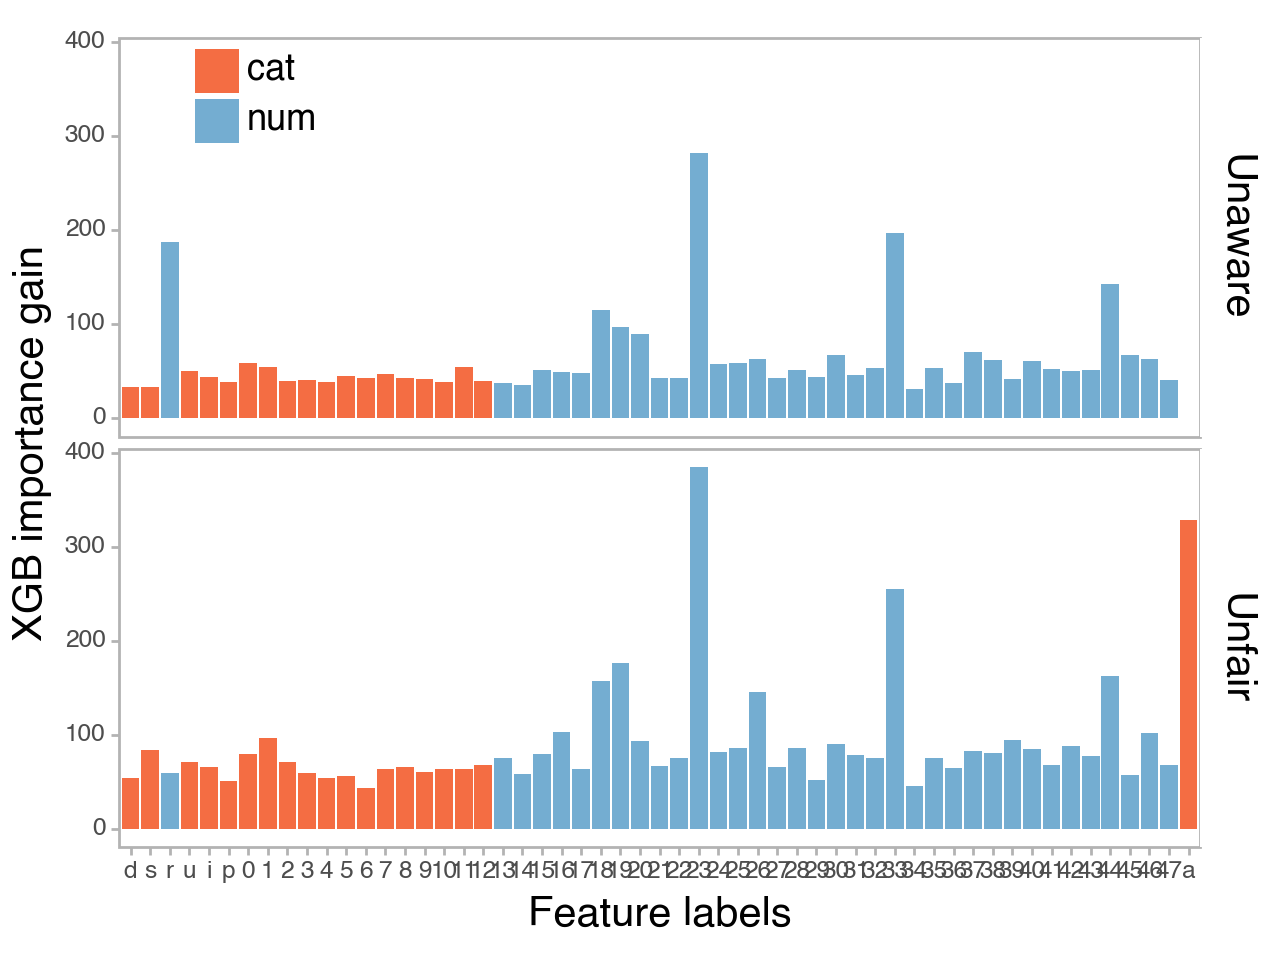

<Figure Size: (640 x 480)>

In [24]:
model_xgb = xgb.XGBClassifier(tree_method='hist')
model_xgb.load_model(here('output/XGB_single_fit.model'))  # load model data
booster = model_xgb.get_booster()
scores = booster.get_score(importance_type='gain')
dict_cols = {}
for i, nm in enumerate(scores.keys()):
    if nm == 'f0':
        dict_cols[nm] = 'd'
    elif nm == 'f1':
        dict_cols[nm] = 's'
    elif nm == 'f53':
        dict_cols[nm] = 'r'
    elif nm == 'f2':
        dict_cols[nm] = 'u'
    elif nm == 'f3':
        dict_cols[nm] = 'i'
    elif nm == 'f4':
        dict_cols[nm] = 'p'
    else:
        dict_cols[nm] = str(i - 5)
data_plot = pd.DataFrame(scores, index=[0]).rename(columns=dict_cols).melt()
data_plot['type'] = data_plot.reset_index()['index'].apply(lambda x: 'cat' if x<=17 else 'num')

model_xgb = xgb.XGBClassifier(tree_method='hist')
model_xgb.load_model(here('output/XGB_single_fit_unfair.model'))  # load model data
booster = model_xgb.get_booster()
scores = booster.get_score(importance_type='gain')
dict_cols = {}
for i, nm in enumerate(scores.keys()):
    if nm == 'f0':
        dict_cols[nm] = 'd'
    elif nm == 'f1':
        dict_cols[nm] = 's'
    elif nm == 'f53':
        dict_cols[nm] = 'r'
    elif nm == 'f2':
        dict_cols[nm] = 'u'
    elif nm == 'f3':
        dict_cols[nm] = 'i'
    elif nm == 'f4':
        dict_cols[nm] = 'p'
    elif nm == 'f54':
        dict_cols[nm] = 'a'
    else:
        dict_cols[nm] = str(i - 5)
data_plot2 = pd.DataFrame(scores, index=[0]).rename(columns=dict_cols).melt()
data_plot2['type'] = data_plot2.reset_index()['index'].apply(lambda x: 'cat' if x<=17 or x==54 else 'num')

data_plot_all = pd.concat([data_plot.assign(label='Unaware'), data_plot2.assign(label='Unfair')], axis=0)
data_plot_all['variable'] = pd.Categorical(data_plot_all['variable'], categories=['d','s','r', 'u', 'i', 'p'] + [str(x) for x in range(0,48)] + ['a'])

plot_imp = (ggplot(data_plot_all,aes(x='variable',y='value')) +
 facet_grid('label ~ .') +
 geom_col(aes(fill='type')) +
 scale_fill_manual(values=['#f46d43','#74add1']) +
 labs(x='Feature labels', y='XGB importance gain') +
 theme_light() +
 theme(panel_grid=element_blank(),
       legend_title=element_blank(),
       strip_background=element_rect(fill='white', linewidth=0),
       strip_text=element_text(color='black', size=15.0),
       legend_direction='vertical',
       legend_position=(0.2,0.9),
       legend_text=element_text(size=13.0),
       axis_title=element_text(size=15.0),
       ))

# plot_imp.save(here('output/xgb_imp_all.pdf'),
#                               height=5,width=11)
plot_imp

## Crosstables between protected attribute and clicks

### Table 5

In [30]:
# Overall frequencies
tab_acs = pd.crosstab(
    index=protected_attribute.astype(int),
    columns=[y.astype(int), is_senior.astype(int)],
    normalize=False,
    rownames=["protected attribute"],
    colnames=["clicks", "senior ads"],
    margins=True,
)
tab_acs

clicks                    0             1            All
senior ads                0       1     0     1         
protected attribute                                     
0                    189982  342221  1274  2636   536113
1                    166394  366140   917  2662   536113
All                  356376  708361  2191  5298  1072226

### Table 6

In [11]:
tab_acs_cond_senior = pd.crosstab(index=is_senior, columns=[protected_attribute], normalize="index", rownames=["senior ads"], colnames=["protected attribute",])
tab_acs_cond_senior

protected attribute,0.0,1.0
senior ads,,
0.0,0.533390,0.466610
1.0,0.483224,0.516776


### Table 7

In [26]:
tab_acs_cond_attribute = pd.crosstab(index=protected_attribute, columns=[y,is_senior], normalize="index", rownames=["protected attribute"], colnames=["clicks","senior ads"])
tab_acs_cond_attribute

clicks                    0.0                 1.0          
senior ads                0.0       1.0       0.0       1.0
protected attribute                                        
0.0                  0.354369  0.638337  0.002376  0.004917
1.0                  0.310371  0.682953  0.001710  0.004965